<a href="https://colab.research.google.com/github/markcastorm/Quantum-Neural-Networks/blob/main/Quantum_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Quantum Neural Networks

 Quantum Neural Networks are quantum algorithms based on parameterized circuits that can be trained in a variational manner using classical optimizers , that contain feature map and an ansatz.

 QNN contains interface and two specific implementations:


  NeuralNetwork: The interface for neural networks. This is an abstract class all QNNs inherit from.

  EstimatorQNN: A network based on the evaluation of quantum mechanical observables.

  SamplerQNN: A network based on the samples resulting from measuring a quantum circuit.


In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_algorithms
!pip install pylatexenc

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed =42

### Lets instatiate QNNs

EstimatorQNN

EstimatorQNN  takes in a parameterized quantum circuit as the input  together as an optional mechanical observable and outputsexpectation value computations for the forward pass,

Here we our quantum circuit has 2 parameters first for representing the QNN input and the other to represents the trainable weights

In [ ]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

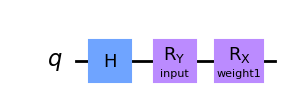

In [ ]:
params1 = [Parameter("input"), Parameter("weight1")]
q1 = QuantumCircuit(1)
q1.h(0)
q1.ry(params1[0], 0)
q1.rx(params1[1], 0)
q1.draw(output="mpl", style="clifford")

Now lets use the Y^n Observable

In [ ]:
from qiskit.quantum_info import SparsePauliOp
obser1 = SparsePauliOp.from_list([("Y" * q1.num_qubits, 1)])

We've defined the quantum circuit and the observable,thw EstimatorQNN constructor gets the keyword arguments (estimator,input_params, weight_params)

In [ ]:
!pip install qiskit-machine-learning

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=q1, observables=obser1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

## SamplerQNN
Its instantiated simila to EstimatorQNN ,but it doesnt require  custom varible since it directly consumes samples from measuring the qubits.


Lets create a quantum circuit for  SamplerQNN.Which will have two input parameters and four trainble weights that prametrize a two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


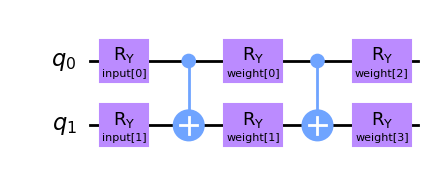

In [ ]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

q2 = QuantumCircuit(2)
q2.ry(inputs2[0], 0)
q2.ry(inputs2[1], 1)
q2.cx(0, 1)

q2.ry(weights2[0], 0)
q2.ry(weights2[1], 1)
q2.cx(0, 1)

q2.ry(weights2[2], 0)
q2.ry(weights2[3], 1)

q2.draw("mpl", style="clifford")

Now we have to specify the inputs and weights when instantiating the samplerQNN and we will be using the default sampler instance.

In [ ]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN( circuit=q2, input_params=inputs2, weight_params=weights2)
sampler_qnn

## Running a Forward Pass

Lets specify random sets of input and weights of the right dimension

In [ ]:
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)


print(
    f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weights}"
)

Number of input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]


Lets do it with samplerQNN

In [ ]:

sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)



Number of input features for SamplerQNN: 2 
Input: [0.85859792 0.69736803]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.09417735 0.97562235 0.7611397  0.78606431]


Now that we have inputs and weights ,lets have a look at the results for the batched and non-batched passes

### Non-Batched Forward Pass

for the estimatorQNN we get the expected output shape of the forwrd pss is (1, num_qubits * num_observables)

1 = number of samples

In [ ]:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]]. 
Shape: (1, 1)


Now for the SamplerQNN that doesnt have a custom interpret function the expected output shape for the forward pass is (1, 2**num_qubits)

In [ ]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
print(f"SamplerQNN Forward pass results output: {sampler_qnn_forward}. \n Shape: {sampler_qnn_forward.shape}")

SamplerQNN Forward pass results output: [[0.01826527 0.25735654 0.5267981  0.19758009]]. 
 Shape: (1, 4)


## Batched Forward Pass

Fore the EstimatorQNN we get the expected output shape of the forward pass to be (batch_size, num_qubits * num_observables):

In [ ]:
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)
print(f"EstimatorQNN Forward pass results output: {estimator_qnn_forward_batched}. \n Shape: {estimator_qnn_forward_batched.shape}")


EstimatorQNN Forward pass results output: [[0.2970094]
 [0.2970094]]. 
 Shape: (2, 1)


For the SamplerQNN  given it doesnt have a custom interpret ,the expectes output shapesfor the forward ass is (batch_size, 2**num_qubits).But if it had a custom interpretor then the shape would be (batch_size , output_shape)

In [ ]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print (
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}. \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]
 [0.01826527 0.25735654 0.5267981  0.19758009]]. 
Shape: (2, 4)


## Backward Pass

Lets Simulate Backward pass without Input Gradients for

EstimatorQNN

In [ ]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights

)
print(f"Input Gradients: {estimator_qnn_input_grad}. \nShape: {estimator_qnn_input_grad}")
print(f"Weights Gradients: {estimator_qnn_weight_grad}. \nShape: {estimator_qnn_weight_grad.shape}")

Input Gradients: None. 
Shape: None
Weights Gradients: [[[0.63272767]]]. 
Shape: (1, 1, 1)


Lets Simulate Backward pass without Input Gradients for

SamplerQNN that doesnt have a custom interpret function thus the expected output shape of the forward pass is (batch_size,2**num_qubits, num_weights)

In [ ]:
sampler_qnn_input_gradients, sampler_qnn_weight_gradients = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)
print(f"Input Gradients: {sampler_qnn_input_gradients}. \nShape: {sampler_qnn_input_gradients}")
print(f"Weights Gradients: {sampler_qnn_weight_gradients}. \nShape: {sampler_qnn_weight_gradients.shape}")

Input Gradients: None. 
Shape: None
Weights Gradients: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]]. 
Shape: (1, 4, 4)


# Now lets test the Backward Pass with input Gradients

First we enable the input_gradients

In [ ]:
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

For the EstimatorQNN with input gradients, expectated output shape  (batch_size, num_qubits * num_observables,num_inputs)

In [ ]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)
print(f"Input Gradients: {estimator_qnn_input_grad}. \nShape: {estimator_qnn_input_grad.shape}")
print(f"Weights Gradients: {estimator_qnn_weight_grad}. \nShape: {estimator_qnn_weight_grad.shape}")

Input Gradients: [[[0.3038852]]]. 
Shape: (1, 1, 1)
Weights Gradients: [[[0.63272767]]]. 
Shape: (1, 1, 1)


For the SamplerQNN with a custom interpret function the output will be (batch_size, output_shape, num_inputs)

In [ ]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)
print(f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}. \nShape: {sampler_qnn_input_grad.shape}")
print(f"Weights gradients for SamplerQNN: {sampler_qnn_weight_grad}. \nShape: {sampler_qnn_weight_grad.shape}")



Input gradients for SamplerQNN: [[[-0.05844702 -0.10621091]
  [ 0.38798796 -0.19544083]
  [-0.34561132  0.09459601]
  [ 0.01607038  0.20705573]]]. 
Shape: (1, 4, 2)
Weights gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]]. 
Shape: (1, 4, 4)


Now lets test out Estimator with Multiple Observables for more complex QNN architectures

In [ ]:
obser2 = SparsePauliOp.from_list([("Z" * q1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=q1,
    observables=[obser1, obser2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [ ]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)
print(f"Forward output for EstimatorQNN: {estimator_qnn_foward}. \nShape: {estimator_qnn_foward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2}. \nShape: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN: {estimator_qnn_weight_grad}. \nShape: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2}. \nShape: {estimator_qnn_weight_grad2.shape}")

Forward output for EstimatorQNN: [[ 0.2970094  -0.63272767]]. 
Shape: (1, 2)
Forward output for EstimatorQNN2: [[ 0.2970094  -0.63272767]]. 
Shape: (1, 2)
Backward output for EstimatorQNN: [[[0.63272767]]]. 
Shape: (1, 1, 1)
Backward output for EstimatorQNN2: [[[0.63272767]
  [0.2970094 ]]]. 
Shape: (1, 2, 1)


##SampleQNN with custom interpret

"Parity" fuction is a function that allows Samplerqnn to perform binary classification (N/B - Using an iterpret function modifies the outputshape of the forward and backward pass).Now given parity interpret function  output_shape is fixed to 2 thus our expected forward and weight gradient shapes are (batch_size, 2) and (batch_size, 2, num_weights)

In [57]:
parity = lambda x: "{:b}" .format(x).count("1") % 2
out_shape = 2
sampler_qnn2 = SamplerQNN(
    circuit=q2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=out_shape,
)




In [59]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)
